In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
temp = pd.read_csv('embeddings/250_0.16_vectors.tsv', sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
#problem_id = list(temp[0])
temp.rename(columns={0:'puzzle_id'}, inplace=True)
temp.set_index('puzzle_id',inplace=True)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [3]:
temp.shape

(42278, 250)

In [4]:
tag_data = pd.read_csv('../tactics_problem.csv')
def get_first_tag(row):
    tags = str(row['tags']).split(',')
    return tags[0]

tag_data['tags'] = tag_data.apply(lambda row: get_first_tag(row),axis=1)
#tag_data = tag_data.loc[(tag_data['tags'] != 'nan') & (tag_data['tags'] != 'Mate in 1')]
tag_data = tag_data.loc[(tag_data['tags'] != 'nan')]
#tag_data = tag_data.loc[tag_data['tags'].isna() == False]

In [5]:
shared_puzzles = pd.merge(tag_data,temp,left_on='tactics_problem_id',right_on='puzzle_id')['tactics_problem_id']

In [6]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
sample_size=1000
sampled_problems = np.random.choice(shared_puzzles.values, size = sample_size, replace = False)
def generate_matrix():
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table

In [7]:
#Generate color pallete
sampled_tags = tag_data.set_index('tactics_problem_id').loc[sampled_problems]['tags']
tag_vals = sampled_tags.unique()
palette = sns.color_palette("hls", len(tag_vals))
lut = dict(zip(tag_vals, palette))
colors = sampled_tags.map(lut)

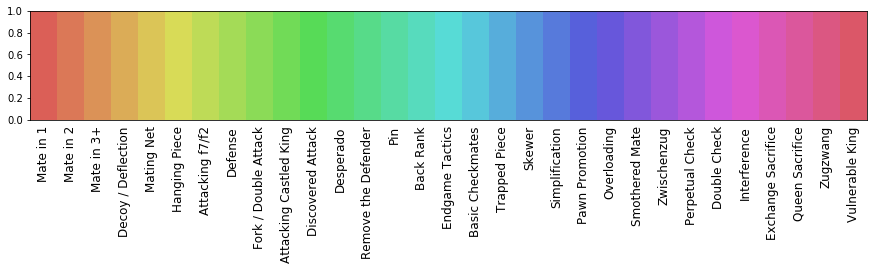

In [9]:
import matplotlib
import matplotlib.pyplot as plt

n=15
size = n/len(tag_vals)
fig = plt.figure(figsize=(n,2))
ax = fig.add_subplot(111)
index = 0
for tag in lut:
    plt.text(index+(size/4), -0.15, tag, fontsize=12,rotation="vertical")
    rect = matplotlib.patches.Rectangle((index,0), size, 2, color=lut[tag])
    ax.add_patch(rect)
    index += size
#ax.set_xticklabels(tag_vals,)
plt.xlim([0, n]) 
plt.tick_params(axis='x',  # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [10]:
#Do clustering on condendesed distance matrix
table = generate_matrix()
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(table), method='complete')

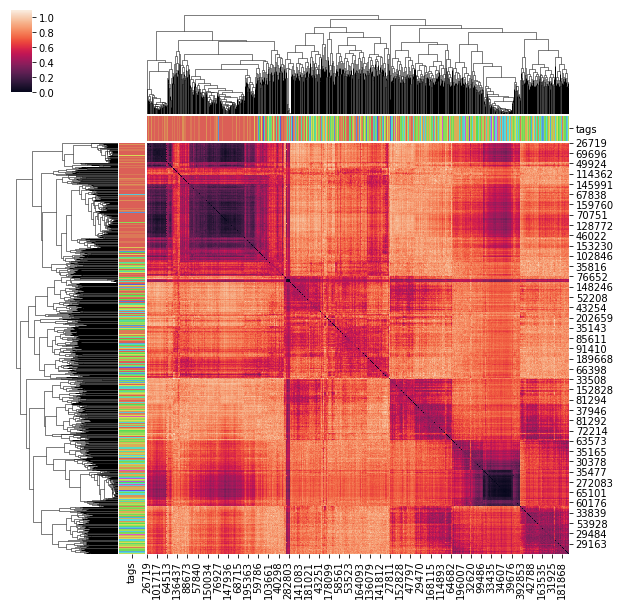

In [11]:
#Set row and column linkage to the clustering genrated above and print heatmap

import seaborn as sns
sns.clustermap(table, row_linkage=linkage, col_linkage=linkage,row_colors=colors,col_colors=colors)